# Content filtering using cosine similarity of tracks

The following notebook illustrates our content filtering approach that uses track similarity (measured by cosine distance) to recommend tracks to playlists.

## 0. Motivation

In order to recommend songs to playlists, we want to recommend songs that share similar features with the existing songs in the playlists. One way to find songs that share similar features with the existing songs is to look at cosine similarity of their audio features. 

The idea is that if they share similar audio features (thus a short cosine distance), they are similar songs.

Cosine similarity measures the orientation of two *n*-dimensional sample vectors irrespective to their magnitude. It is calculated by the dot product of two numeric vectors, and it is normalized by the product of the vector lengths. 
The output value ranges from 0 to 1, with 1 as the highest similarity.

We compute a similarity matrix for tracks by using sklearn pairwise distance method, with cosine similairty:

<h><center>$cos(\pmb track_1, \pmb track_2) = \frac{\pmb track_1 \cdot \pmb track_2}{||\pmb track_1|| \cdot ||\pmb track_2||}$ </h>

## 0.1 Strategy

To compute prediction set per playlist, our model does the following:
1. The model looks at individual track of the playlist (from the training set) and find the cosine distance of that track and all other tracks in our training set.
2. It recommends the top k similar songs per track until the recommendation list has reached its pre-determined limit (which is test-set size * 15)

## 1. Data Processing

### 1.1 Train-test split 
We did a stratified splitting of the data (by Playlistid) into training and test set by 80-20. Stratified splitting ensures that we have the right proportion of train and test for playlists of different lengths.

### 1.2 Data cleaning
We drop some non-numeric features in order to calculate the cosine similarity matrix. Below shows the first few rows of our training data (with the audio features of individual tracks).

In [5]:
train_cleaned.head()

,Track_Duration,acousticness,artist_popularity,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,221939,0.72300,84,0.714,0.343,0.000005,10,0.1020,-7.641,1,0.3800,72.348,4,0.372
1,246213,0.02810,71,0.770,0.421,0.000000,0,0.1110,-8.255,0,0.0849,131.935,4,0.214
2,216120,0.01970,86,0.399,0.787,0.000061,1,0.0685,-2.880,1,0.0499,117.089,5,0.572
3,304200,0.04070,77,0.681,0.570,0.000000,7,0.1050,-5.829,0,0.1360,135.121,4,0.153
4,256946,0.00164,60,0.545,0.905,0.000002,7,0.0532,-10.732,1,0.0648,103.574,4,0.826


### 1.3 Create a cosine-similarity matrix
We create a cosine-similarity matrix of the individual tracks in the training set. The shape of the cosine matrix shows 2463 unique tracks (in 100 playlists) in the training set.

In [7]:
train_scaled_cos_matrix.shape

(2463, 2463)

Here's the cosine similarity of the first 5 tracks in the training set. We expect the diagnoal of the matrix to be 1, because it is referring to the same song.

In [8]:
train_scaled_cos_matrix[:5]

array([[1.        , 0.70370129, 0.81424758, ..., 0.87263617, 0.79012625,
        0.76284813],
       [0.70370129, 1.        , 0.82541858, ..., 0.77956107, 0.89152418,
        0.82271377],
       [0.81424758, 0.82541858, 1.        , ..., 0.93027042, 0.81602446,
        0.72451838],
       [0.79433301, 0.93252096, 0.80163412, ..., 0.86770269, 0.90692581,
        0.89966543],
       [0.85392504, 0.74018692, 0.9374127 , ..., 0.96500088, 0.84458619,
        0.79398798]])

In [17]:
train.head()

,Playlistid,Trackid,Artist_Name,Track_Name,Album_Name,Track_Duration,Artist_uri,Track_uri,Album_uri,acousticness,...,loudness,mode,speechiness,tempo,time_signature,valence,Playlist,Album,Track,Artist
0,231023,4,Chance The Rapper,Blessings,Coloring Book,221939,spotify:artist:1anyVhU62p31KFi8MEzkbf,spotify:track:2VQc9orzwE6a5qFfy54P6e,spotify:album:71QyofYesSsRMwFOTafnhB,0.72300,...,-7.641,1,0.3800,72.348,4,0.372,Chance The Rapper,21,38,16
1,249966,51,Chief Keef,Love Sosa,Finally Rich,246213,spotify:artist:15iVAtD3s3FsQR4w1v6M0P,spotify:track:4IowQDUOzUvNtp72HMDcKO,spotify:album:6VML3yX1WR5pXtg6fmwdzZ,0.02810,...,-8.255,0,0.0849,131.935,4,0.214,Rap,37,53,28
2,2535,46,Sia,Chandelier,1000 Forms Of Fear,216120,spotify:artist:5WUlDfRSoLAfcVSX1WnrxN,spotify:track:4VrWlk8IQxevMvERoX08iC,spotify:album:3xFSl9lIRaYXIYkIn3OIl9,0.01970,...,-2.880,1,0.0499,117.089,5,0.572,Feel Good,94,102,85
3,58121,26,Fetty Wap,No Days Off (feat. Monty),Fetty Wap,304200,spotify:artist:6PXS4YHDkKvl1wkIl4V8DL,spotify:track:3wr2fJ91iGjZlrcDLJ6bYp,spotify:album:2gKQvajkEEaDtkqJ8FJ4uw,0.04070,...,-5.829,0,0.1360,135.121,4,0.153,Grindin,31,38,23
4,67941,1,Spin Doctors,Two Princes,Pocket Full Of Kryptonite (Anniversary Edition),256946,spotify:artist:2PSiyldxmJze7xiqbz658m,spotify:track:0cuq829zRNq4AEdmDJA4aw,spotify:album:3jx5C8Z66FwdjNkqsSDBQh,0.00164,...,-10.732,1,0.0648,103.574,4,0.826,90's,26,28,21


Just an example, we can  look at the distribution of cosine distance of an individual track to all other tracks in the training set.

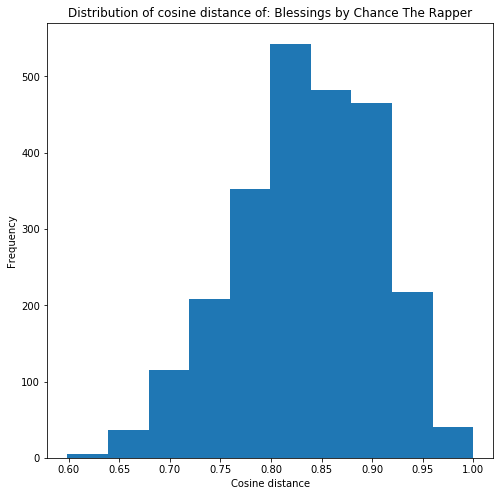

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.hist(train_scaled_cos_matrix[:1][0])
plt.xlabel("Cosine distance")
plt.ylabel("Frequency")
plt.title("Distribution of cosine distance of: Blessings by Chance The Rapper")
plt.show()

We can see a somewhat normal distribution of cosine distance, that most songs have >= 0.6 cosine distance to 'Blessings', with a peak at 0.80-0.85. 

## 2. Model Performance 
### 2.1 Metrics

We used the following metrics to evaluate our model, based on Spotify RecSys [rules](https://recsys-challenge.spotify.com/rules)

1. **R-precision**: the number of retrieved relevant tracks divided by the number of known relevant tracks (i.e., the number of withheld tracks). This metric rewards total number of retrieved relevant tracks (regardless of order).

2. **NDCG**: Discounted cumulative gain (DCG) measures the ranking quality of the recommended tracks, increasing when relevant tracks are placed higher in the list. Normalized DCG (NDCG) is determined by calculating the DCG and dividing it by the ideal DCG in which the recommended tracks are perfectly ranked.



$$
\text{R-precision} = \frac{|G \cap R|}{|G|}
$$


$$
\begin{align*}
\text{DCG} &= rel_i + \sum^{|\text{R}|}_{i=2}\frac{rel_i}{log_2(i+1)} \\
\text{IDCG} &= 1 + \sum^{|G|}_{i=2}\frac{1}{log_2(i+1)} \\
\text{NDCG} &= \frac{\text{DCG}}{\text{IDCG}}
\end{align*}
$$


### 2.2 Model Test-Set Performance

| Data | R-Precision | NDCG | Average of the two metrics |
|------|------|------|----- |
|Test set of 100 playlists | 0.045856|0.051839|0.048847|
|Test set of 1000 playlists | 0.033373|0.042258|0.037815|

## 3. Conclusion

In conclusion, content filtering outperforms our baseline model that uses collaborative filtering on co-occurrence. 

Interestingly, we did not see an improvement in score when predicting on a larger dataset (with more unique tracks and playlists). 

Source code: https://github.com/phoebewong/spotify-teamNPK/blob/master/src